In [ ]:
import yfinance as yfin
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
df = yfin.download('GC=F','2021-01-01','2023-12-30')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,1912.199951,1945.099976,1912.199951,1944.699951,1944.699951,154
2021-01-05,1941.699951,1952.699951,1941.300049,1952.699951,1952.699951,113
2021-01-06,1952.000000,1959.900024,1901.500000,1906.900024,1906.900024,331
2021-01-07,1922.599976,1926.699951,1912.000000,1912.300049,1912.300049,122
2021-01-08,1908.000000,1908.000000,1834.099976,1834.099976,1834.099976,60


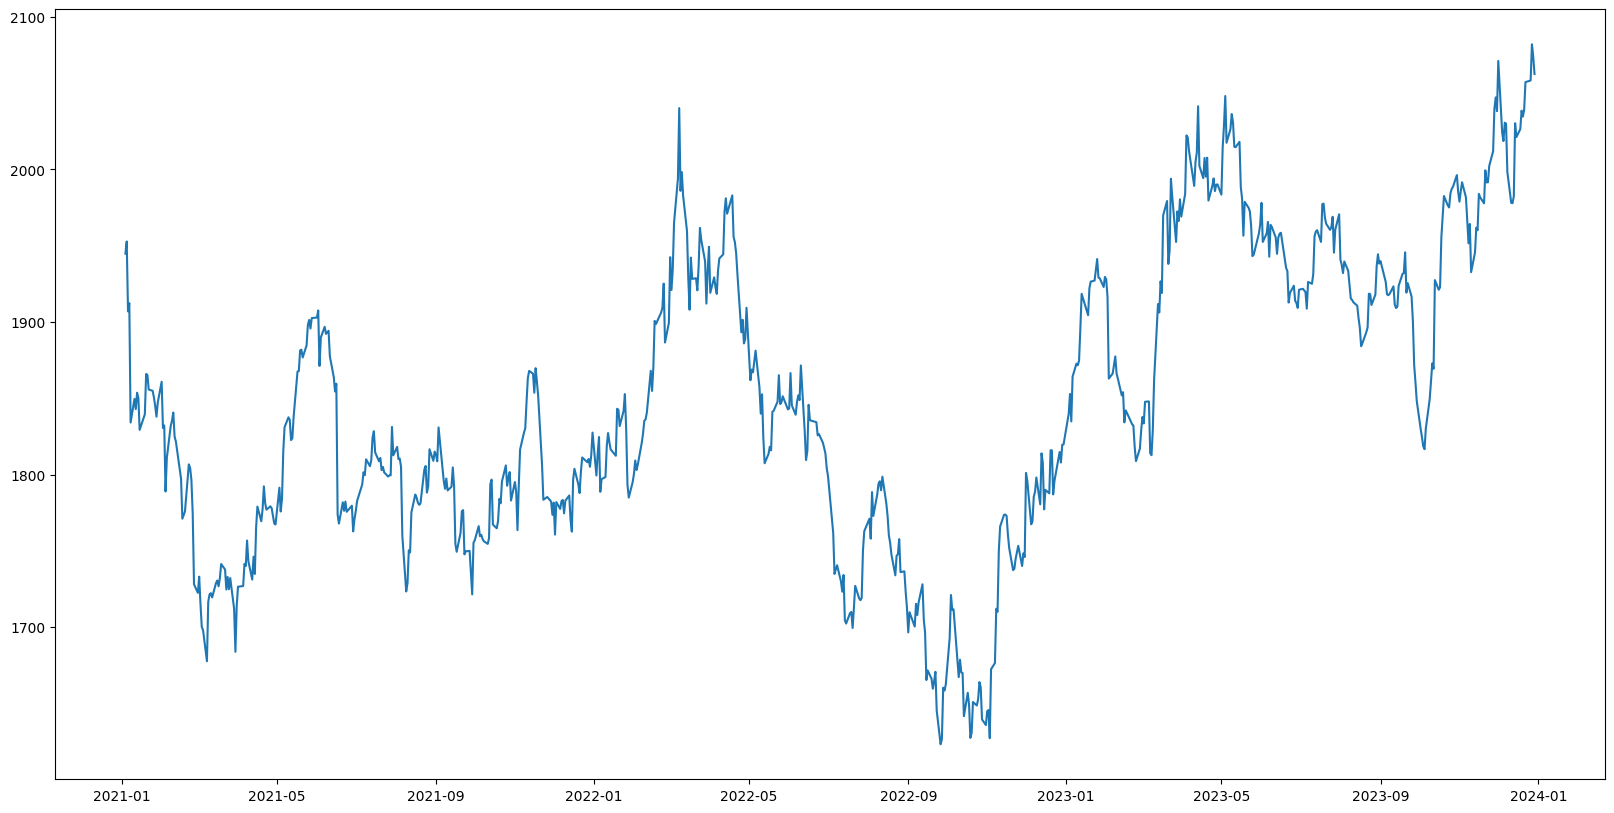

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df['Adj Close'])
plt.show()

***arranging columns***

In [ ]:
def arrange_cols(df):
    df['Adj Close'] , df['Volume'] =  df['Volume'] ,df['Adj Close']
    df.columns = ['Open','High','Low','Close','Volume','Adj Close']
    return df
df = arrange_cols(df)
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2021-01-04,1912.199951,1945.099976,1912.199951,1944.699951,154,1944.699951
2021-01-05,1941.699951,1952.699951,1941.300049,1952.699951,113,1952.699951
2021-01-06,1952.000000,1959.900024,1901.500000,1906.900024,331,1906.900024
2021-01-07,1922.599976,1926.699951,1912.000000,1912.300049,122,1912.300049
2021-01-08,1908.000000,1908.000000,1834.099976,1834.099976,60,1834.099976


***Scaling the values to range[0,1]***

In [ ]:
scaler = MinMaxScaler()
def scale(df):
    df = pd.DataFrame(scaler.fit_transform(df))
    return df
df = scale(df)
df.head()


,0,1,2,3,4,5
0,0.632697,0.634839,0.658174,0.700829,0.000734,0.700829
1,0.696661,0.649832,0.722641,0.718273,0.000539,0.718273
2,0.718994,0.664036,0.634471,0.618404,0.001578,0.618404
3,0.655247,0.598540,0.657732,0.630179,0.000582,0.630179
4,0.623590,0.561649,0.485157,0.459660,0.000286,0.459660


***Creating Features and Target in the shape of (samples,timestep,features)***

In [ ]:
def X_y_creation(df):
    sample = 10
    X = []
    y = []
    for i in range(df.shape[0]-sample):
      X.append(df.iloc[i:i+sample,0:5])
      y.append(df.iloc[i+sample,5:])
    X = np.array(X)
    y = np.array(y)
    return X , y

In [ ]:
X , y = X_y_creation(df)
print(f"Shape of X:{X.shape}\nShape of y:{y.shape}")

Shape of X:(744, 10, 5)
Shape of y:(744, 1)


In [ ]:
print(X[20],y[1])

[[0.30920367 0.29382716 0.27476079 0.26783866 0.00616351]
 [0.27714585 0.2704938  0.27760546 0.27003612 0.00569636]
 [0.27378482 0.25790111 0.21683484 0.21406412 0.01132122]
 [0.22479321 0.23481475 0.22730805 0.2425026  0.00609201]
 [0.25323168 0.26345667 0.25071117 0.26964842 0.00121077]
 [0.28632369 0.27160494 0.27876903 0.27404349 0.0008771 ]
 [0.28722849 0.28123448 0.28691494 0.28089448 0.00258839]
 [0.28451394 0.27370364 0.2660978  0.26059981 0.00286963]
 [0.26447774 0.25209871 0.2509697  0.25633398 0.00123461]
 [0.25917788 0.24703701 0.22265331 0.22479309 0.00543895]] [0.31359879]


In [ ]:
trainx , valx , trainy , valy = train_test_split(X,y,train_size = 0.8)

***Network Building***

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Input((X.shape[1],X.shape[2])))
model.add(keras.layers.SimpleRNN(30 , activation = 'tanh' ,
                                 use_bias = True,
                                 kernel_initializer = 'glorot_uniform',
                                 kernel_regularizer = keras.regularizers.L1L2(l1=1e-4,l2=1e-4)))
model.add(keras.layers.Dense(1))

model.compile(loss = 'mean_squared_error',
              optimizer = 'adam')

In [ ]:
model.evaluate(valx,valy)

6/6 [==============================] - 0s 3ms/step - loss: 0.0637


0.06374045461416245

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss',
                          patience = 50,
                          mode = 'auto',
                          restore_best_weights= True,
                          min_delta = 0.00005)

In [ ]:
history = model.fit(trainx,trainy,
          validation_data = (valx,valy),
          epochs = 500,
          batch_size = 128,
          verbose = 2,
          callbacks = [earlystop])

Epoch 1/500
6/6 - 2s - loss: 0.3549 - val_loss: 0.0409 - 2s/epoch - 272ms/step
Epoch 2/500
6/6 - 0s - loss: 0.0541 - val_loss: 0.0909 - 106ms/epoch - 18ms/step
Epoch 3/500
6/6 - 0s - loss: 0.0717 - val_loss: 0.0246 - 102ms/epoch - 17ms/step
Epoch 4/500
6/6 - 0s - loss: 0.0191 - val_loss: 0.0209 - 86ms/epoch - 14ms/step
Epoch 5/500
6/6 - 0s - loss: 0.0229 - val_loss: 0.0171 - 94ms/epoch - 16ms/step
Epoch 6/500
6/6 - 0s - loss: 0.0136 - val_loss: 0.0096 - 95ms/epoch - 16ms/step
Epoch 7/500
6/6 - 0s - loss: 0.0104 - val_loss: 0.0108 - 86ms/epoch - 14ms/step
Epoch 8/500
6/6 - 0s - loss: 0.0099 - val_loss: 0.0078 - 95ms/epoch - 16ms/step
Epoch 9/500
6/6 - 0s - loss: 0.0077 - val_loss: 0.0080 - 88ms/epoch - 15ms/step
Epoch 10/500
6/6 - 0s - loss: 0.0077 - val_loss: 0.0070 - 105ms/epoch - 18ms/step
Epoch 11/500
6/6 - 0s - loss: 0.0068 - val_loss: 0.0067 - 96ms/epoch - 16ms/step
Epoch 12/500
6/6 - 0s - loss: 0.0066 - val_loss: 0.0063 - 91ms/epoch - 15ms/step
Epoch 13/500
6/6 - 0s - loss: 0.006

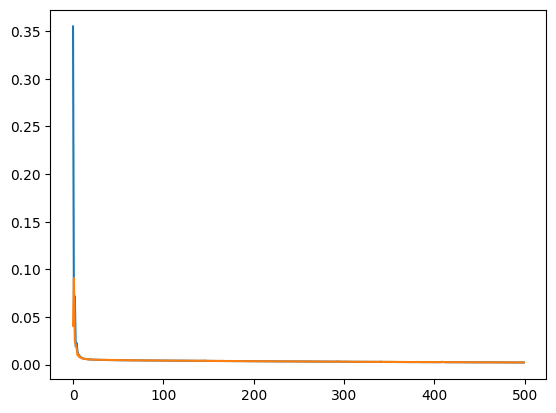

In [ ]:
plt.plot(pd.DataFrame(history.history).loc[:,'loss'],label = ['training loss'])
plt.plot(pd.DataFrame(history.history).loc[:,'val_loss'],label = ['validation loss'])

In [ ]:
ypred = model.predict(valx)

6/6 [==============================] - 0s 3ms/step


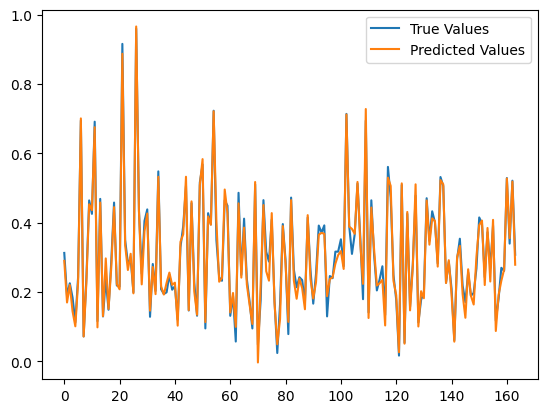

In [ ]:
plt.plot(pd.DataFrame(valy) ,label = 'True Values')
plt.plot(pd.DataFrame(ypred) ,label = 'Predicted Values')
plt.legend()
plt.show()

***Testing with some Foreign data***

In [ ]:
ex = yfin.download('GC=F','2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
ex.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,2063.500000,2073.699951,2057.100098,2064.399902,2064.399902,61
2024-01-03,2034.199951,2044.000000,2034.199951,2034.199951,2034.199951,54
2024-01-04,2041.599976,2044.500000,2038.000000,2042.300049,2042.300049,88
2024-01-05,2044.500000,2048.100098,2042.400024,2042.400024,2042.400024,12
2024-01-08,2019.099976,2033.699951,2019.099976,2026.599976,2026.599976,10


In [ ]:
ex = arrange_cols(ex)
ex = scale(ex)
ex_x , ex_y = X_y_creation(ex)

In [ ]:
ex_pred = model.predict(ex_x)

3/3 [==============================] - 0s 5ms/step


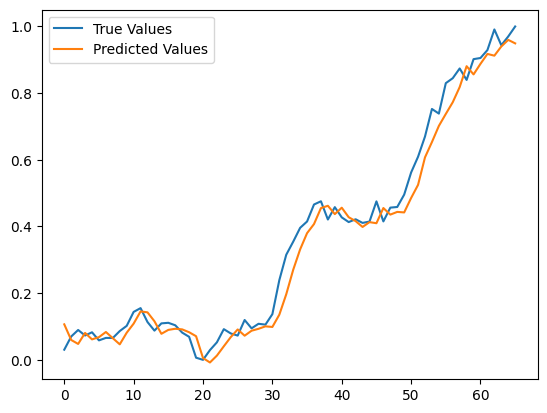

In [ ]:
plt.plot(pd.DataFrame(ex_y) ,label = 'True Values')
plt.plot(pd.DataFrame(ex_pred) ,label = 'Predicted Values')
plt.legend()
plt.show()